In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 22.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re
import string
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

from tqdm.auto import tqdm
import tensorflow as tf
from transformers import BertTokenizer
from tensorflow.keras.models import save_model

import pickle

import warnings
warnings.simplefilter('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Sentiment_Analysis_Test/dataset/clean_subset_1_2_3.csv')
df.head()

,Unnamed: 0,ID,Month,Product,Text,Rating,Polarity
0,0,664840,2019 / 12,HUMIDIFICATION-PHARMACY,use couple week different bedroom love first s...,1,Negative
1,1,1133039,2021 / 04,HUMIDIFICATION-PHARMACY,little machine problem blow frigid air however...,1,Negative
2,2,1250864,2022 / 11,HUMIDIFICATION-PHARMACY,box damage open box arrive out box,1,Negative
3,3,669332,2019 / 01,HUMIDIFICATION-PHARMACY,machine quit work month never go away knew air...,1,Negative
4,4,1135686,2021 / 04,HUMIDIFICATION-PHARMACY,take box follow instruction light come work wo...,1,Negative


In [ ]:
data = df[['Text', 'Rating']]
data.head()

,Text,Rating
0,use couple week different bedroom love first s...,1
1,little machine problem blow frigid air however...,1
2,box damage open box arrive out box,1
3,machine quit work month never go away knew air...,1
4,take box follow instruction light come work wo...,1


In [ ]:
data

,Text,Rating
0,use couple week different bedroom love first s...,1
1,little machine problem blow frigid air however...,1
2,box damage open box arrive out box,1
3,machine quit work month never go away knew air...,1
4,take box follow instruction light come work wo...,1
...,...,...
24880,love easy usefull,5
24881,buenisimo,5
24882,easy help tremendously sinus,5
24883,excellent,5


In [ ]:
data['Rating'] = data['Rating'] - 1

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [ ]:
token = tokenizer.encode_plus(
    data['Text'].iloc[0], 
    max_length=256, 
    truncation=True, 
    padding='max_length', 
    add_special_tokens=True,
    return_tensors='tf'
)

In [ ]:
X_input_ids = np.zeros((len(data), 256))
X_attn_masks = np.zeros((len(data), 256))

In [ ]:
def generate_training_data(data, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(data['Text'])):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=256, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

In [ ]:
X_input_ids, X_attn_masks = generate_training_data(data, X_input_ids, X_attn_masks, tokenizer)

0it [00:00, ?it/s]

In [ ]:
labels = np.zeros((len(data), 5))
labels.shape

(24885, 5)

In [ ]:
labels[np.arange(len(data)), data['Rating'].values] = 1 # one-hot encoded target tensor

In [ ]:
labels

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))
dataset.take(1) # one sample data

<TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
def SentimentDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

In [ ]:
dataset = dataset.map(SentimentDatasetMapFunction) # converting to required format for tensorflow dataset

In [ ]:
dataset = dataset.shuffle(10000).batch(16, drop_remainder=True) # batch size, drop any left out tensor

In [ ]:
p = 0.8
train_size = int((len(df)//16)*p) # for each 16 batch of data we will have len(df)//16 samples, take 80% of that for train.

In [ ]:
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [ ]:
from transformers import TFBertModel

In [ ]:
model = TFBertModel.from_pretrained('bert-base-cased') # bert base model with pretrained weights

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# defining 2 input layers for input_ids and attn_masks
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')

bert_embds = model.bert(input_ids, attention_mask=attn_masks)[1] # 0 -> activation layer (3D), 1 -> pooled output layer (2D)
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embds)
output_layer = tf.keras.layers.Dense(5, activation='softmax', name='output_layer')(intermediate_layer) # softmax -> calcs probs of classes

sentiment_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
sentiment_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [ ]:
optim = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-6)
loss_func = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [ ]:
sentiment_model.compile(optimizer=optim, loss=loss_func, metrics=[acc,])

In [30]:
hist = sentiment_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=1,
    callbacks=[callback]
)

1244/1244 [==============================] - 1134s 901ms/step - loss: 1.2799 - accuracy: 0.4407 - val_loss: 1.0787 - val_accuracy: 0.5303


In [31]:
preds = sentiment_model.predict(val_dataset)

311/311 [==============================] - 91s 287ms/step


In [32]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in val_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = sentiment_model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
correct_labels = tf.argmax(correct_labels,axis=1)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 0s 295ms/step


In [33]:
cm = confusion_matrix(predicted_labels,correct_labels)
cm_df = pd.DataFrame(cm,columns = ['Not Recommended', 'Below Average', 'Average', 'Good', 'Excellent'],index = ['Not Recommended', 'Below Average', 'Average', 'Good', 'Excellent'])

In [34]:
cm_df

,Not Recommended,Below Average,Average,Good,Excellent
Not Recommended,470,216,49,13,22
Below Average,50,144,35,4,2
Average,142,379,518,147,55
Good,31,69,310,438,140
Excellent,36,45,81,530,1050


In [35]:
from sklearn.metrics import classification_report
print(classification_report(correct_labels,predicted_labels))

              precision    recall  f1-score   support

           0       0.61      0.64      0.63       729
           1       0.61      0.17      0.26       853
           2       0.42      0.52      0.46       993
           3       0.44      0.39      0.41      1132
           4       0.60      0.83      0.70      1269

    accuracy                           0.53      4976
   macro avg       0.54      0.51      0.49      4976
weighted avg       0.53      0.53      0.50      4976



<AxesSubplot:>

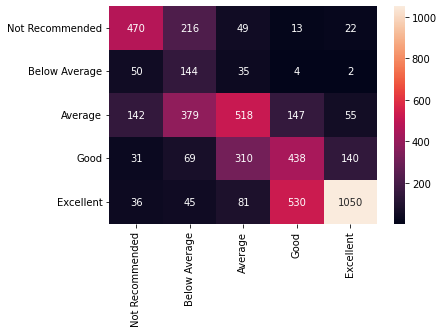

In [36]:
import seaborn as sns
sns.heatmap(cm_df,annot=True,fmt='g')

In [38]:
save_model(sentiment_model, filepath = "/content/drive/MyDrive/Sentiment_Analysis_Test/model/5_sentiment_BERT_Clean_Subdataset_1_2_3.hdf5")